[*********************100%***********************]  6 of 6 completed

Determined Optimal Weights :
       Weights
AAPL  0.289030
GOOG  0.239921
TSLA  0.005181
MSFT  0.052220
AMZN  0.203405
HCL   0.210242
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Portfolio expected return:  2.4194210479704177
Portfolio risk is : 15.354242813944563

Expected Return and Risk:
      Expected Return       Risk
AAPL         0.107883   2.818378
GOOG         0.101655   1.943779
TSLA         0.212501   3.608038
MSFT         0.109663   2.133014
AMZN         0.172293   3.602636
HCL         11.044290  72.783984

Correlation Coefficients:
          A

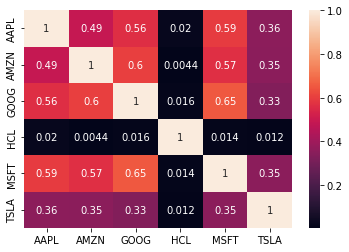

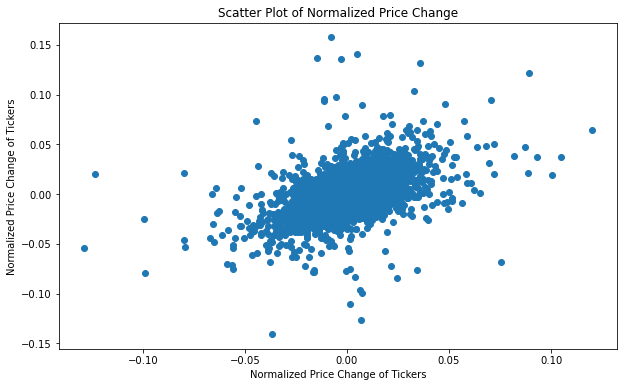


GMM Metrics:
Log-Likelihood: 18.287441505906934
BIC: -117517.939272416
AIC: -118534.36978839507


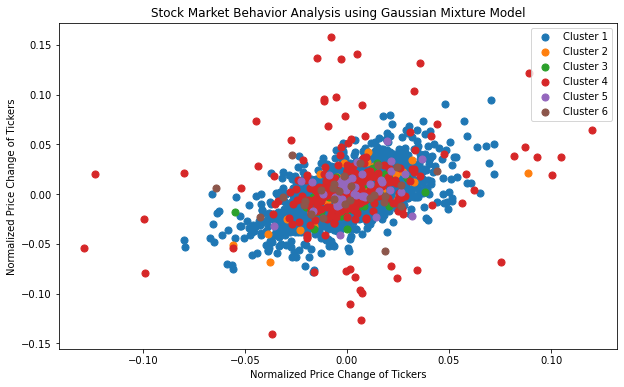


Gaussian HMM Metrics:
Log-Likelihood: 55290.06034684319
BIC: -109755.30684560335
AIC: -110376.12069368637


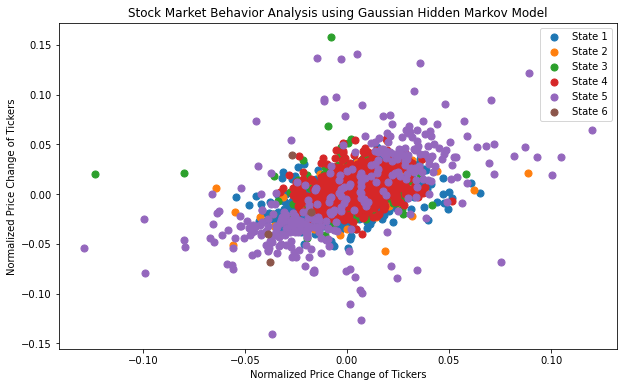

In [5]:
import yfinance as yf
import scipy.optimize as sco
from scipy.optimize import minimize
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbols
tickers = ['AAPL', 'GOOG', 'TSLA', 'MSFT', 'AMZN', 'HCL']

class Statistics:
    def __init__(self, lst):
        self.lst = lst

    def mean(self):
        return sum(self.lst) / len(self.lst)

    def var(self):
        x_bar = self.mean()
        return sum((x - x_bar) ** 2 for x in self.lst) / len(self.lst)

    def stdev(self):
        return self.var() ** 0.5


class Portfolio:
    def __init__(self, n_companies, weights, ticker):
        self.n_companies = n_companies
        self.weights = weights
        self.ticker = ticker
        self.returns, self.exp_return, self.risk = self.risk_return_individual()

    def risk_return_individual(self):
        returns = []
        exp_return = []
        risk = []
        for ticker in self.ticker:
            data = yf.download(ticker, period='max', interval='1d')
            lst = data['Close']
            ret = [(lst[j + 1] - lst[j]) / lst[j] * 100 for j in range(len(lst) - 1)]
            ret_stats = Statistics(ret)
            returns.append(ret)
            exp_return.append(ret_stats.mean())
            risk.append(ret_stats.stdev())
        return returns, exp_return, risk 

    def portfolio_return(self):
        port_returns = sum(a * b for a, b in zip(self.weights, self.exp_return))
        print('Portfolio expected return: ', port_returns)

    def portfolio_risk(self):
        term_1 = sum([w*w*r*r for w, r in zip(self.weights,self.risk)])
        cov_matrix = np.zeros((self.n_companies,self.n_companies))
        for i in range(self.n_companies):
            for j in range(self.n_companies):
                returns_i = pd.Series(self.returns[i])
                returns_j = pd.Series(self.returns[j])
                cov_matrix[i][j] = returns_i.cov(returns_j)

        term_2 = 2*(sum([self.weights[i]*self.weights[j]*cov_matrix[i][j] for i in range(self.n_companies) for j in range(i+1, self.n_companies)]))
        port_risk = (term_1 + term_2)**0.5
        print('Portfolio risk is :', port_risk)


# Download historical stock prices
data = yf.download(tickers, period='max', interval='1d')['Close']
returns = data.pct_change().dropna()

# Calculate expected returns and covariance matrix
expected_returns = returns.mean()
covariance_matrix = returns.cov()

# Define objective function and constraints
def objective(weights):
    portfolio_return = np.dot(weights.T, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio

constraints = [{'type': 'eq', 'fun': lambda a: np.sum(a) - 1}]  # Constraint: sum of weights equals 1
bounds = [(0, 1) for _ in tickers]  # Bounds: each weight between 0 and 1

# Find optimal weights using optimization
initial_weights = np.ones(len(tickers)) / len(tickers)  # Initial guess: equal weights
result = sco.minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Get determined optimal weights
optimal_weights = result.x

weights_df = pd.DataFrame(optimal_weights, index = tickers, columns = ['Weights'])
print('\nDetermined Optimal Weights :')
print(weights_df)

# Create Portfolio object
portfolio = Portfolio(len(tickers), optimal_weights, tickers)

# Calculate portfolio return and risk
portfolio.portfolio_return()
portfolio.portfolio_risk()

# Retrieve expected returns and risks corresponding to tickers
exp_return = portfolio.exp_return
risk = portfolio.risk
ret_risk_df = pd.DataFrame({'Expected Return': exp_return, 'Risk': risk}, index=tickers)
print("\nExpected Return and Risk:")
print(ret_risk_df)

# Calculate correlation matrix
correlation_matrix = returns.corr()

# Calculate correlation coefficients
correlation_coefficients = pd.DataFrame(correlation_matrix, columns=tickers, index=tickers)
print("\nCorrelation Coefficients:")
print(correlation_coefficients)

# Heatmap
sns.heatmap(correlation_matrix, annot=True)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(returns.iloc[:, 0], returns.iloc[:, 1])
plt.xlabel('Normalized Price Change of Tickers')
plt.ylabel('Normalized Price Change of Tickers')
plt.title('Scatter Plot of Normalized Price Change')
plt.show()

# Gaussian Mixture Model(GMM)
gmm = GaussianMixture(n_components=6)
gmm.fit(returns)

# Predict the clusters for each data point
labels = gmm.predict(returns)

# Calculate log-likelihood
log_likelihood = gmm.score(returns)

# Calculate BIC
bic = gmm.bic(returns)

# Calculate AIC
aic = gmm.aic(returns)

# Print the metrics
print("\nGMM Metrics:")
print("Log-Likelihood:", log_likelihood)
print("BIC:", bic)
print("AIC:", aic)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(gmm.n_components):
    plt.scatter(returns.iloc[labels == i, 0], returns.iloc[labels == i, 1], s=50, label=f'Cluster {i + 1}')
plt.legend()
plt.xlabel('Normalized Price Change of Tickers')
plt.ylabel('Normalized Price Change of Tickers')
plt.title('Stock Market Behavior Analysis using Gaussian Mixture Model')
plt.show()

# GaussianHMM
n_states = 6
hmm = GaussianHMM(n_components=n_states)
hmm.fit(returns)

# Predict the hidden states for each data point
hidden_states = hmm.predict(returns)

# Calculate log-likelihood
log_likelihood = hmm.score(returns)

# Calculate the number of parameters
n_features = returns.shape[1]
n_params = n_states * (n_states - 1) + 2 * n_states * n_features

# Calculate BIC
bic = -2 * log_likelihood + n_params * np.log(len(returns))

# Calculate AIC
aic = -2 * log_likelihood + 2 * n_params

# Print the metrics
print("\nGaussian HMM Metrics:")
print("Log-Likelihood:", log_likelihood)
print("BIC:", bic)
print("AIC:", aic)

# Plot the results
plt.figure(figsize=(10, 6))
for i in range(n_states):
    plt.scatter(returns.iloc[hidden_states == i, 0], returns.iloc[hidden_states == i, 1], s=50, label=f'State {i + 1}')
plt.legend()
plt.xlabel('Normalized Price Change of Tickers')
plt.ylabel('Normalized Price Change of Tickers')
plt.title('Stock Market Behavior Analysis using Gaussian Hidden Markov Model')
plt.show()